Запуск анализа данных
Оставленный instrument_id: 2820
Количество trade_time с несколькими сделками: 0


C:\Users\wertu\AppData\Local\Temp\ipykernel_13772\3588226218.py:29: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  most_common_instrument = trades_df.group_by('instrument_id').agg(count=pl.count()).sort('count', descending=True).head(1)['instrument_id'][0]
C:\Users\wertu\AppData\Local\Temp\ipykernel_13772\3588226218.py:40: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  trade_time_counts = trades_df.group_by('trade_time').agg(count=pl.count())


Статистика временных разрывов (нс):
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 199444.0   │
│ null_count ┆ 2.068815e6 │
│ mean       ┆ 1.7616e19  │
│ std        ┆ 3.8249e18  │
│ min        ┆ 0.0        │
│ 25%        ┆ 1.8447e19  │
│ 50%        ┆ 1.8447e19  │
│ 75%        ┆ 1.8447e19  │
│ max        ┆ 1.8447e19  │
└────────────┴────────────┘


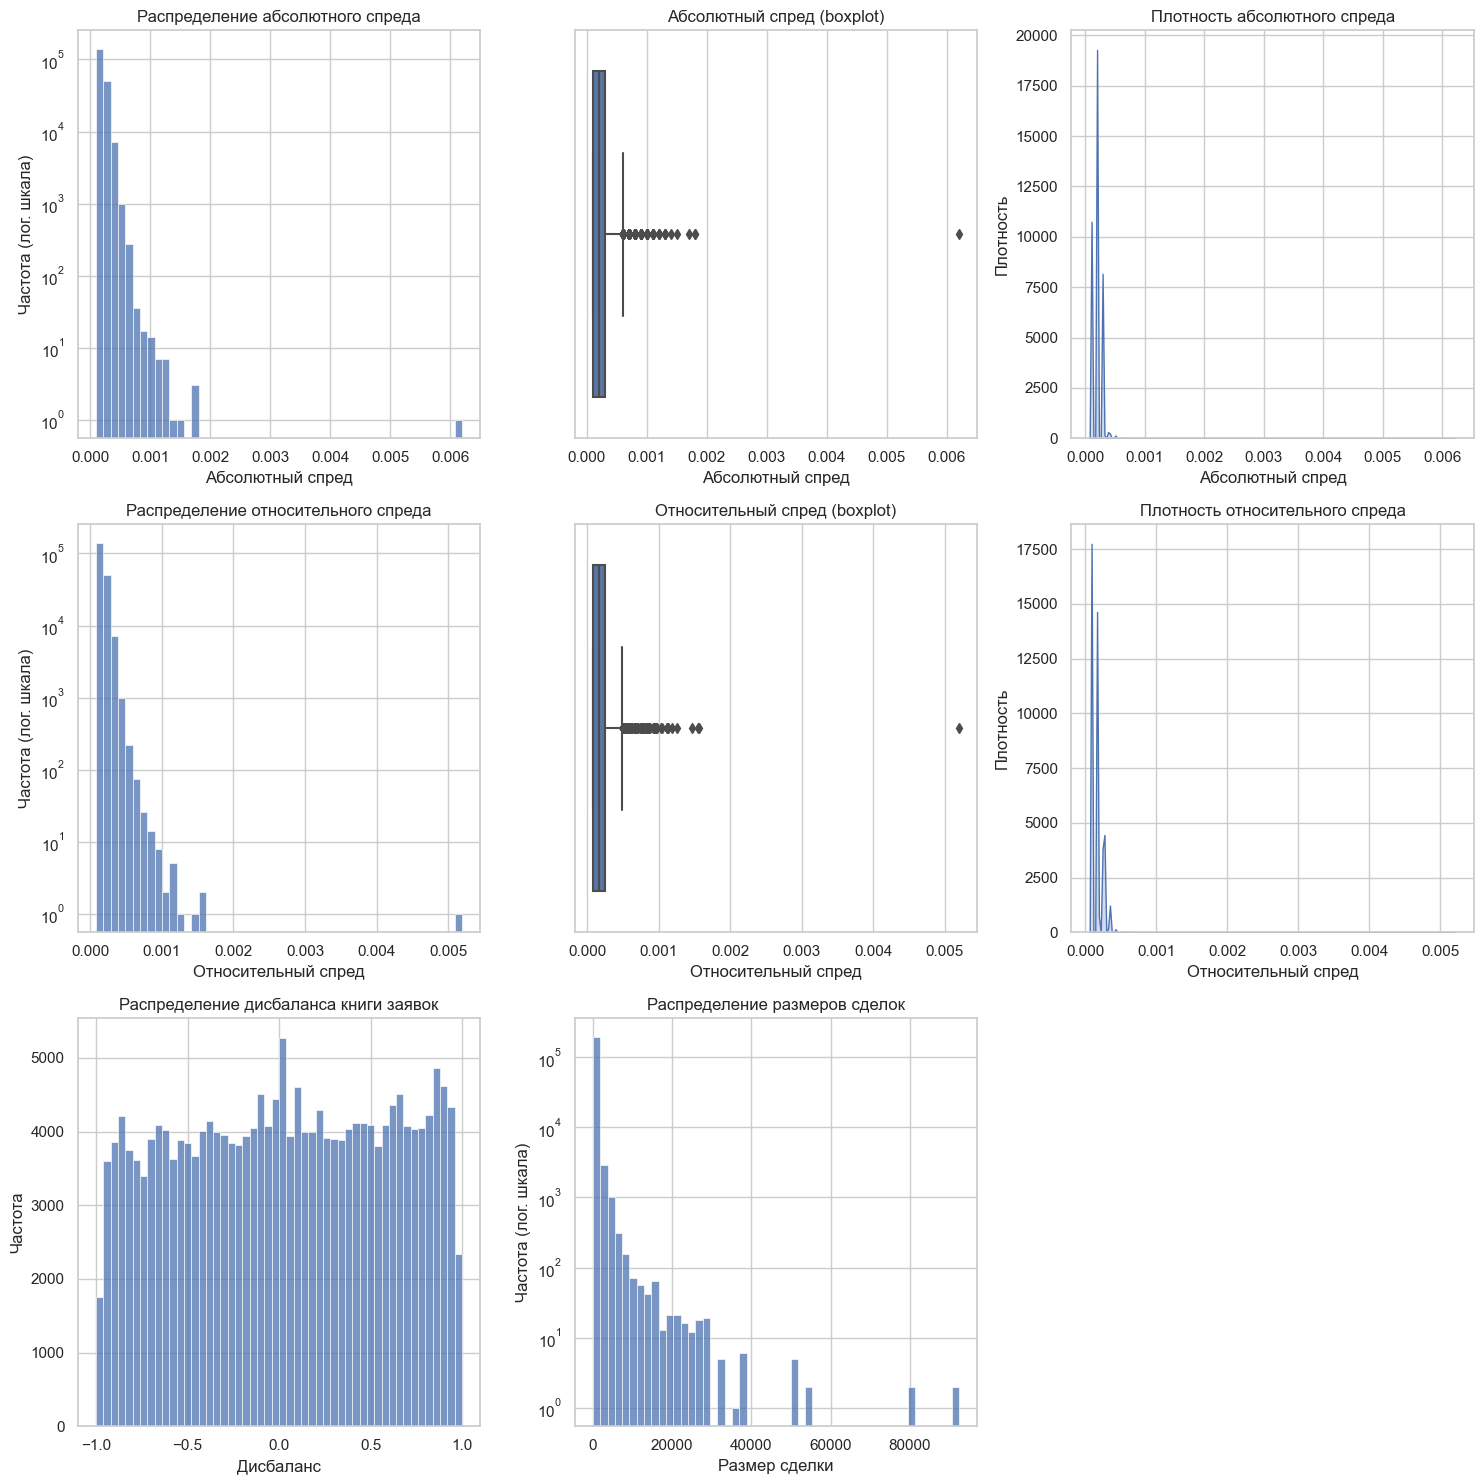

Доходности:


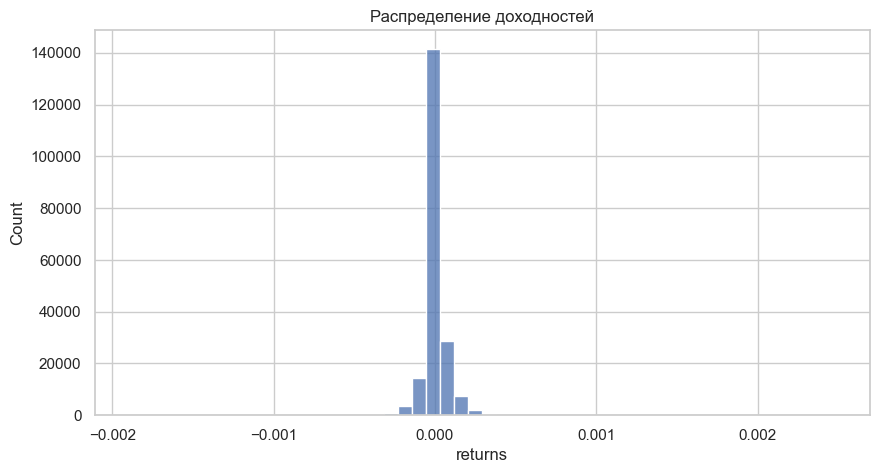

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 199444.0   │
│ null_count ┆ 0.0        │
│ mean       ┆ -2.1817e-7 │
│ std        ┆ 0.000069   │
│ min        ┆ -0.00189   │
│ 25%        ┆ 0.0        │
│ 50%        ┆ 0.0        │
│ 75%        ┆ 0.0        │
│ max        ┆ 0.002477   │
└────────────┴────────────┘
Анализ закономерностей и аномалий:
Средний абсолютный спред: 0.0002
Выбросы абсолютного спреда (>3σ): 1342
Средний относительный спред: 0.0002
Выбросы относительного спреда (>3σ): 1335
Средний дисбаланс: 0.0246
Экстремальный дисбаланс (|x| > 0.8): 37489
Средний размер сделки: 306.8984
Выбросы размера сделки (>3σ): 1926
shape: (5, 4)
┌─────────────────────┬────────────┬────────────┬────────────────┐
│ exchange_time       ┆ bid_size_1 ┆ ask_size_1 ┆ book_imbalance │
│ ---                 ┆ ---        ┆ ---        ┆ ---            │
│ u64                 ┆ f64   

In [14]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Callable, Any
import os
from scipy.stats import pearsonr, shapiro
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


plt.style.use('ggplot')
sns.set_theme(style="whitegrid")


bybit_path = "C:/Users/wertu/quant_assignment/data/parsed_ondo/2820_2025-02-18_bybit_trade_fc.parquet"
order_path_bybit = "C:/Users/wertu/quant_assignment/data/parsed_ondo/2820_2025-02-18_bybit_book_1_fc.parquet"

trades_bybit = pl.read_parquet(bybit_path)
order_bybit = pl.read_parquet(order_path_bybit)

def preprocess_data(trades_df: pl.DataFrame, order_df: pl.DataFrame) -> pl.DataFrame:
    """Предобработка"""
    most_common_instrument = trades_df.group_by('instrument_id').agg(count=pl.count()).sort('count', descending=True).head(1)['instrument_id'][0]
    trades_df = trades_df.filter(pl.col('instrument_id') == most_common_instrument)
    order_df = order_df.filter(pl.col('instrument_id') == most_common_instrument)
    print("Оставленный instrument_id:", most_common_instrument)

    # Агрегация сделок
    trades_df = trades_df.group_by('trade_time').agg(
        instrument_id=pl.col('instrument_id').first(),
        quantity=pl.col('quantity').sum()
    ).sort('trade_time')

    trade_time_counts = trades_df.group_by('trade_time').agg(count=pl.count())
    print("Количество trade_time с несколькими сделками:", trade_time_counts.filter(pl.col('count') > 1).height)

    order_df = order_df.select(['instrument_id', 'exchange_time', 'bid_price_0', 'bid_qty_0', 'ask_price_0', 'ask_qty_0'])

    order_df = order_df.rename({
        'bid_price_0': 'bid_price_1',
        'bid_qty_0': 'bid_size_1',
        'ask_price_0': 'ask_price_1',
        'ask_qty_0': 'ask_size_1'
    })

    order_df = order_df.sort('exchange_time')

    order_df = order_df.with_columns(
        ((pl.col('bid_price_1') + pl.col('ask_price_1')) / 2).alias('mid_price')
    )

    order_df = order_df.with_columns([
        (pl.col('ask_price_1') - pl.col('bid_price_1')).alias('spread'),
        ((pl.col('ask_price_1') - pl.col('bid_price_1')) / pl.col('mid_price')).alias('relative_spread'),
        ((pl.col('bid_size_1') - pl.col('ask_size_1')) / (pl.col('bid_size_1') + pl.col('ask_size_1'))).alias('book_imbalance')
    ])

    # Фильтрация аномалий
    order_df = order_df.filter((pl.col('bid_size_1') + pl.col('ask_size_1')) > 1.0)
    order_df = order_df.filter(pl.col('mid_price') > 0)
    order_df = order_df.filter(pl.col('bid_size_1') > 10.0).filter(pl.col('ask_size_1') > 10.0)  # Фильтр для устранения экстремального дисбаланса

    df = order_df.join_asof(
        trades_df,
        left_on='exchange_time',
        right_on='trade_time',
        strategy='backward',
        tolerance=100_000_000  # 100 мс
    )

    
    df = df.with_columns(
        (pl.col('trade_time') - pl.col('exchange_time')).alias('time_diff_ns')
    )
    print("Статистика временных разрывов (нс):")
    print(df['time_diff_ns'].describe())

  
    df = df.with_columns(
        ((pl.col('mid_price') / pl.col('mid_price').shift(1)) - 1).alias('returns')
    )

    return df.drop_nulls().sort('exchange_time')

def analyze_patterns(df: pl.DataFrame):
    """Анализ закономерностей и аномалий."""
    print("Анализ закономерностей и аномалий:")
    
    # Абсолютный спред
    spread_mean = df['spread'].mean()
    spread_std = df['spread'].std()
    spread_outliers = df.filter(pl.col('spread') > spread_mean + 3 * spread_std).height
    print(f"Средний абсолютный спред: {spread_mean:.4f}")
    print(f"Выбросы абсолютного спреда (>3σ): {spread_outliers}")
    
    # Относительный спред
    rel_spread_mean = df['relative_spread'].mean()
    rel_spread_std = df['relative_spread'].std()
    rel_spread_outliers = df.filter(pl.col('relative_spread') > rel_spread_mean + 3 * rel_spread_std).height
    print(f"Средний относительный спред: {rel_spread_mean:.4f}")
    print(f"Выбросы относительного спреда (>3σ): {rel_spread_outliers}")
    
    # Дисбаланс
    imbalance_mean = df['book_imbalance'].mean()
    imbalance_std = df['book_imbalance'].std()
    imbalance_extreme = df.filter(pl.col('book_imbalance').abs() > 0.8).height
    print(f"Средний дисбаланс: {imbalance_mean:.4f}")
    print(f"Экстремальный дисбаланс (|x| > 0.8): {imbalance_extreme}")
    
    # Размеры сделок
    trade_size_mean = df['quantity'].mean()
    trade_size_std = df['quantity'].std()
    trade_size_outliers = df.filter(pl.col('quantity') > trade_size_mean + 3 * trade_size_std).height
    print(f"Средний размер сделки: {trade_size_mean:.4f}")
    print(f"Выбросы размера сделки (>3σ): {trade_size_outliers}")
    
    extreme_imbalance = df.filter(pl.col('book_imbalance').abs() > 0.8)
    print(extreme_imbalance[['exchange_time', 'bid_size_1', 'ask_size_1', 'book_imbalance']].head())
    
    outliers_spread = df.filter(pl.col('spread') > df['spread'].mean() + 3 * df['spread'].std())
    print(outliers_spread[['exchange_time', 'spread', 'mid_price', 'quantity']].head())
    
    print("Экстремальный дисбаланс (|x| > 0.8):")
    print(extreme_imbalance[['exchange_time', 'bid_size_1', 'ask_size_1', 'book_imbalance']].describe())

def main():
    print("Запуск анализа данных")
    
    df = preprocess_data(trades_bybit, order_bybit)
    
    os.makedirs('plots', exist_ok=True)
    
    df_pd = df.to_pandas()
    
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 3, 1)
    sns.histplot(df_pd['spread'], bins=50, log_scale=(False, True))
    plt.title('Распределение абсолютного спреда')
    plt.xlabel('Абсолютный спред')
    plt.ylabel('Частота (лог. шкала)')

    plt.subplot(3, 3, 2)
    sns.boxplot(x=df_pd['spread'])
    plt.title('Абсолютный спред (boxplot)')
    plt.xlabel('Абсолютный спред')

    plt.subplot(3, 3, 3)
    sns.kdeplot(df_pd['spread'], fill=True)
    plt.title('Плотность абсолютного спреда')
    plt.xlabel('Абсолютный спред')
    plt.ylabel('Плотность')

    plt.subplot(3, 3, 4)
    sns.histplot(df_pd['relative_spread'], bins=50, log_scale=(False, True))
    plt.title('Распределение относительного спреда')
    plt.xlabel('Относительный спред')
    plt.ylabel('Частота (лог. шкала)')

    plt.subplot(3, 3, 5)
    sns.boxplot(x=df_pd['relative_spread'])
    plt.title('Относительный спред (boxplot)')
    plt.xlabel('Относительный спред')

    plt.subplot(3, 3, 6)
    sns.kdeplot(df_pd['relative_spread'], fill=True)
    plt.title('Плотность относительного спреда')
    plt.xlabel('Относительный спред')
    plt.ylabel('Плотность')

    plt.subplot(3, 3, 7)
    sns.histplot(df_pd['book_imbalance'], bins=50)
    plt.title('Распределение дисбаланса книги заявок')
    plt.xlabel('Дисбаланс')
    plt.ylabel('Частота')

    plt.subplot(3, 3, 8)
    sns.histplot(df_pd['quantity'], bins=50, log_scale=(False, True))
    plt.title('Распределение размеров сделок')
    plt.xlabel('Размер сделки')
    plt.ylabel('Частота (лог. шкала)')

    plt.tight_layout()
    plt.savefig('plots/distributions.png')
    plt.show()
    
    print("Доходности:")
    plt.figure(figsize=(10, 5))
    sns.histplot(df['returns'].to_pandas(), bins=50)
    plt.title('Распределение доходностей')
    plt.show()
    print(df['returns'].describe())

    analyze_patterns(df)
#второе задание
    Q25 = df['book_imbalance'].quantile(0.25)
    Q75 = df['book_imbalance'].quantile(0.75)

    df = df.with_columns([
        (pl.col('book_imbalance') > Q75).alias('is_high_imbalance'),
        (pl.col('book_imbalance') < Q25).alias('is_low_imbalance')
    ])

    def check_price_movement(mid_prices, start_idx, lookahead=10):
        current_price = mid_prices[start_idx]
        threshold = current_price * 1.0001  # 1 bps
        end_idx = min(start_idx + lookahead + 1, len(mid_prices))
        next_prices = mid_prices[start_idx + 1:end_idx]
        return 1 if np.any(next_prices >= threshold) else 0

    mid_prices = df['mid_price'].to_numpy()
    event_A_B1 = np.full(len(df), np.nan)
    event_A_B2 = np.full(len(df), np.nan)

    for i in range(len(df) - 10):
        if df['is_high_imbalance'][i]:
            event_A_B1[i] = check_price_movement(mid_prices, i)
        if df['is_low_imbalance'][i]:
            event_A_B2[i] = check_price_movement(mid_prices, i)

    df = df.with_columns([
        pl.Series('event_A_B1', event_A_B1),
        pl.Series('event_A_B2', event_A_B2)
    ])

    total_B1 = df['is_high_imbalance'].sum()
    A_and_B1 = df.filter((pl.col('is_high_imbalance') == True) & (pl.col('event_A_B1') == 1)).height
    P_A_given_B1 = A_and_B1 / total_B1 if total_B1 > 0 else 0

    total_B2 = df['is_low_imbalance'].sum()
    A_and_B2 = df.filter((pl.col('is_low_imbalance') == True) & (pl.col('event_A_B2') == 1)).height
    P_A_given_B2 = A_and_B2 / total_B2 if total_B2 > 0 else 0

    print(f"Условная вероятность P(A|B1) для верхнего квартиля дисбаланса: {P_A_given_B1:.4f}")
    print(f"Условная вероятность P(A|B2) для нижнего квартиля дисбаланса: {P_A_given_B2:.4f}")

    spread_median = df['spread'].median()
    trade_size_90th = df['quantity'].quantile(0.9)

    df = df.with_columns([
        (pl.col('spread') > spread_median).alias('is_wide_spread'),
        (pl.col('spread') < spread_median).alias('is_narrow_spread'),
        (pl.col('quantity') > trade_size_90th).alias('is_large_trade')
    ])

    total_B1 = df['is_wide_spread'].sum()
    A_and_B1 = df.filter((pl.col('is_wide_spread') == True) & (pl.col('is_large_trade') == True)).height
    P_A_given_B1 = A_and_B1 / total_B1 if total_B1 > 0 else 0

    total_B2 = df['is_narrow_spread'].sum()
    A_and_B2 = df.filter((pl.col('is_narrow_spread') == True) & (pl.col('is_large_trade') == True)).height
    P_A_given_B2 = A_and_B2 / total_B2 if total_B2 > 0 else 0

    print(f"Условная вероятность P(A|B1) для спреда шире медианы: {P_A_given_B1:.4f}")
    print(f"Условная вероятность P(A|B2) для спреда уже медианы: {P_A_given_B2:.4f}")
#третье задание
    print("\nСтатистическое тестирование гипотез")
    print("Гипотеза: Дисбаланс книги заявок влияет на последующие доходности")

    lags = [1, 3, 5]
    print("Корреляция с лагами:")
    for lag in lags:
        corr_data = df.with_columns(
            pl.col('book_imbalance').shift(lag).alias(f'imbalance_lag_{lag}')
        ).select([f'imbalance_lag_{lag}', 'returns']).drop_nulls()
        corr, p_value = pearsonr(corr_data[f'imbalance_lag_{lag}'].to_numpy(), corr_data['returns'].to_numpy())
        print(f"Лаг {lag}: Корреляция = {corr:.4f}, p-значение = {p_value:.4f}")

    X_lin = df['book_imbalance'].shift(1).fill_null(0)
    y_lin = df['returns']
    reg_data = pl.DataFrame({'const': 1, 'imbalance_lag_1': X_lin, 'returns': y_lin}).drop_nulls()
    X_reg = reg_data[['const', 'imbalance_lag_1']].to_numpy()
    y_reg = reg_data['returns'].to_numpy()
    lin_model = sm.OLS(y_reg, X_reg).fit()
    print("\nЛинейная регрессия (лаг 1):")
    print(lin_model.summary())

    residuals = lin_model.resid
    stat, p_shapiro = shapiro(residuals[:5000])
    print(f"Тест Шапиро на нормальность остатков: p-значение = {p_shapiro:.4f}")

    # Тесты на стационарность (ADF)
    granger_data = df.select(['returns', 'book_imbalance']).to_pandas().dropna()
    print("\nТесты на стационарность (ADF):")
    for column in ['returns', 'book_imbalance']:
        result = adfuller(granger_data[column])
        print(f"ADF тест для {column}: p-значение = {result[1]:.4f}, Стационарность: {'Да' if result[1] < 0.05 else 'Нет'}")

    # Тест Гренджера
    print("\nТест Гренджера (максимум 5 лагов):")
    granger_result = grangercausalitytests(granger_data[['returns', 'book_imbalance']], maxlag=5, verbose=False)
    for lag, result in granger_result.items():
        print(f"Лаг {lag}: p-значение F-теста = {result[0]['ssr_ftest'][1]:.4f}")

    features = ['book_imbalance', 'spread', 'bid_size_1', 'ask_size_1']
    X_rf = df.select(features).to_numpy()
    y_rf = df['returns'].to_numpy()
    tscv = TimeSeriesSplit(n_splits=5)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    mse_scores = []
    for train_idx, test_idx in tscv.split(X_rf):
        X_train, X_test = X_rf[train_idx], X_rf[test_idx]
        y_train, y_test = y_rf[train_idx], y_rf[test_idx]
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, y_pred))
    print(f"\nСлучайный лес - Средняя MSE на кросс-валидации: {np.mean(mse_scores):.6f}")

    rf_model.fit(X_rf, y_rf)
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nВажность признаков в случайном лесе:")
    print(feature_importance)

    return 0

if __name__ == "__main__":
    main()